In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn


In [47]:
x_moons, y_moons=make_moons(n_samples=1000, random_state=42)
x_moons

array([[ 0.00872719,  0.36817352],
       [ 0.921384  , -0.49690497],
       [ 0.94022577, -0.49821192],
       ...,
       [ 1.64091013, -0.26761592],
       [-0.91991616,  0.39211512],
       [ 0.80079841,  0.59893397]])

In [48]:
x_moons=torch.from_numpy(x_moons).type(torch.float)
y_moons=torch.from_numpy(y_moons).type(torch.float)
torch.unique(y_moons)

tensor([0., 1.])

In [49]:
x_train,x_test,y_train,y_test= train_test_split(x_moons,y_moons, test_size=0.2, random_state=42)
len(x_train), len(x_test)

(800, 200)

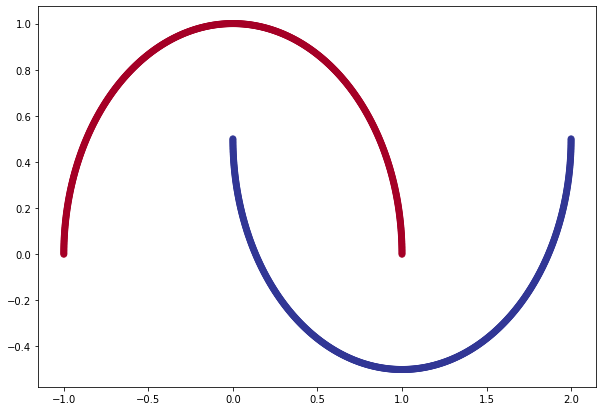

In [50]:
plt.figure(figsize=(10,7))
plt.scatter(x_moons[:,0],x_moons[:,1], c=y_moons, cmap=plt.cm.RdYlBu)

In [51]:
#build model
#device
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [52]:
#model

class MoonModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(in_features=2, out_features=32)
    self.layer2=nn.ReLU()
    self.layer3=nn.Linear(in_features=32, out_features=32)
    self.layer4=nn.ReLU()
    self.layer5=nn.Linear(in_features=32, out_features=1)

  def forward(self, x):
    return self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))

model=MoonModel().to(device)
model

MoonModel(
  (layer1): Linear(in_features=2, out_features=32, bias=True)
  (layer2): ReLU()
  (layer3): Linear(in_features=32, out_features=32, bias=True)
  (layer4): ReLU()
  (layer5): Linear(in_features=32, out_features=1, bias=True)
)

In [53]:
model.state_dict()

OrderedDict([('layer1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
                 

In [54]:
from torch.nn.modules.loss import BCEWithLogitsLoss
###loss and optimizer

loss_fn=BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model.parameters(), lr=0.1)


In [55]:
###check data device

x_train,y_train=x_train.to(device), y_train.to(device)
x_test,y_test=x_test.to(device),y_test.to(device)

###set seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

##set epochs
epochs=1000


In [56]:
!pip install torchmetrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
from torchmetrics import Accuracy

metrics_accuracy=Accuracy(task="multiclass",num_classes=2).to(device)


In [58]:
###train and test loop

for epoch in range(epochs):
  model.train()

  logits=model(x_train).squeeze()
  y_pred=torch.round(torch.sigmoid(logits))

  loss=loss_fn(logits,y_train)
  train_acc=metrics_accuracy(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()
  optimizer.step()
  ######test
  model.eval()
  with torch.inference_mode():
    test_logits=model(x_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    loss_test=loss_fn(test_logits,y_test)
    test_acc=metrics_accuracy(test_pred,y_test)


  if epoch % 100 == 0 :
    print(f"epoch:{epoch} | loss: {loss:.5f} , acc: {train_acc:.2f} % | test loss:{loss_test:.5f} ,test acc: {test_acc:.2f} %")

epoch:0 | loss: 0.69887 , acc: 0.26 % | test loss:0.69115 ,test acc: 0.29 %
epoch:100 | loss: 0.25137 , acc: 0.88 % | test loss:0.25795 ,test acc: 0.88 %
epoch:200 | loss: 0.19234 , acc: 0.91 % | test loss:0.19240 ,test acc: 0.92 %
epoch:300 | loss: 0.14282 , acc: 0.94 % | test loss:0.14338 ,test acc: 0.94 %
epoch:400 | loss: 0.09147 , acc: 0.96 % | test loss:0.09168 ,test acc: 0.98 %
epoch:500 | loss: 0.05292 , acc: 0.99 % | test loss:0.05241 ,test acc: 1.00 %
epoch:600 | loss: 0.03121 , acc: 1.00 % | test loss:0.03049 ,test acc: 1.00 %
epoch:700 | loss: 0.02016 , acc: 1.00 % | test loss:0.01947 ,test acc: 1.00 %
epoch:800 | loss: 0.01417 , acc: 1.00 % | test loss:0.01359 ,test acc: 1.00 %
epoch:900 | loss: 0.01062 , acc: 1.00 % | test loss:0.01014 ,test acc: 1.00 %


In [59]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("it already exists")
else:
  print("downloading")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

it already exists


In [60]:
from helper_functions import  plot_predictions, plot_decision_boundary

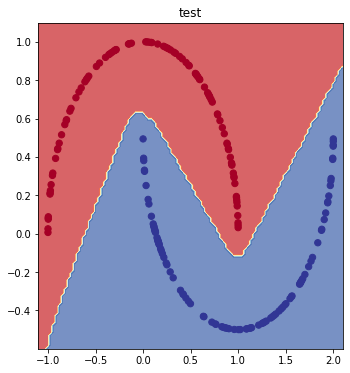

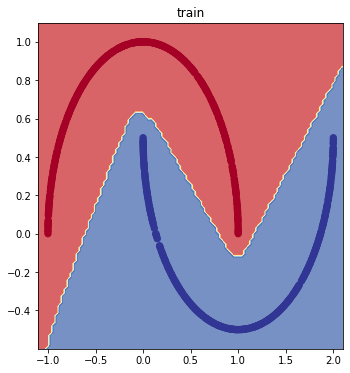

In [61]:
###make predictins
model.eval()
with torch.inference_mode():
  logits_test=model(x_test.to(device))
  test_pred=torch.round(torch.sigmoid(logits_test))
  
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.title('test')
  plot_decision_boundary(model,x_test,test_pred)

  
plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
plt.title('train')
plot_decision_boundary(model,x_train,y_train)


